# Import


In [1]:
import pandas as pd 
import numpy as np

import tensorflow as tf
import torch
from torch import nn

import matplotlib.pyplot as plt 
import seaborn as sns
from PIL import Image
sns.set_style('darkgrid')

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import re 
import string
import time 
import warnings
warnings.filterwarnings("ignore")
from collections import Counter

from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,f1_score,recall_score,precision_score,accuracy_score

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np

from tensorflow.python.client import device_lib                        
from keras.preprocessing import sequence                 
from keras.models import Sequential                      
 

from keras import regularizers
from keras.layers import Dense, Input, Flatten ,LSTM
from keras.layers import Conv1D, MaxPooling1D,GlobalMaxPooling1D, Embedding, Dropout, Activation,AveragePooling1D,BatchNormalization,Bidirectional
from keras.models import Model
from keras.callbacks import ModelCheckpoint

import transformers as ppb
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import BertModel, BertTokenizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [1]:
!pip install transformers
!wget https://users.dcc.uchile.cl/~jperez/beto/uncased_2M/pytorch_weights.tar.gz 
!wget https://users.dcc.uchile.cl/~jperez/beto/uncased_2M/vocab.txt 
!wget https://users.dcc.uchile.cl/~jperez/beto/uncased_2M/config.json 
!tar -xzvf pytorch_weights.tar.gz
!mv config.json pytorch/.
!mv vocab.txt pytorch/.

     |████████████████████████████████| 3.1 MB 12.3 MB/s 
     |████████████████████████████████| 895 kB 32.5 MB/s 
     |████████████████████████████████| 596 kB 50.7 MB/s 
     |████████████████████████████████| 3.3 MB 38.6 MB/s 
     |████████████████████████████████| 59 kB 7.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
--2021-11-21 11:57:32--  https://users.dcc.uchile.cl/~jperez/beto/uncased_2M/pytorch_weights.tar.gz
Resolving users.dcc.uchile.cl (users.dcc.uchile.cl)... 200.9.99.211, 192.80.24.4
Connecting to users.dcc.uchile.cl (users.dcc.uchile.cl)|200.9.99.211|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 410039235 (391M) [application/x-gzip]
Saving to: ‘pytorch_weights.tar.gz’

pytorch_weights.tar 100%[===================>] 391.04M  6.10MB/s    in 61s     

2021-11-21 11:58:34 (6.40 MB/s) - ‘pytorch_weights.tar.gz’ saved [410039235/4100392

# Read data

In [2]:
data_true = pd.read_excel('/content/drive/MyDrive/data/data_10000.xlsx')
data_fake = pd.read_excel('/content/drive/MyDrive/data/fake news Esp.xlsx',sheet_name='all')
data_fake_2 = pd.read_excel('/content/drive/MyDrive/data/fake_v2.xlsx')

In [3]:
N = 2600
data_true = data_true.groupby(['source','media','tag'], group_keys=False).apply(lambda x: x.sample(int(np.rint(N*len(x)/len(data_true))),random_state=42)).sample(frac=1,random_state=42).reset_index(drop=True)

In [4]:
data_true['label'] = 1
data_fake['label'] = 0
data_fake_2['label'] = 0
print(data_true.shape)
print(data_fake.shape)
print(data_fake_2.shape)

(2599, 7)
(2433, 11)
(181, 7)


In [5]:
data_fake['Headlines'].fillna('',inplace=True)
data_fake['Fake statement'] = data_fake['Headlines'].astype(str) +" "+ data_fake["Fake statement"] 
data_fake_2['headline'].fillna('',inplace=True)
data_fake_2['text'] = data_fake_2['headline'].astype(str) +" "+ data_fake_2["text"] 

In [6]:
data_fake.tail(3)

,Topic,Link source,Media,Date,author,Headlines,Fake statement,Full text,Type,Local,label
2430,Terrorismo,https://www.facebook.com/PeriodicoElFuete/phot...,Facebook,2019-11-23 00:00:00,Periódico El Fuete,,He aquí la foto más impactante que dejó la mo...,NaN,NaN,NaN,0
2431,Terrorismo,https://www.abc.es/espana/canarias/abci-reino-...,ABC,2018-07-15 00:00:00,NaN,Reino Unido advierte de ataques terroristas en...,Reino Unido advierte de ataques terroristas en...,NaN,NaN,NaN,0
2432,Terrorismo,NaN,whatsapp,NaN,NaN,,Hay peligro de un atentado inminente en Sevil...,NaN,NaN,NaN,0


In [7]:
data_fake_2.head(3)

,category,topic,source,headline,text,link,label
0,Fake,Health,20 Minutos,Crema de semen para rejuvenecer la piel,Crema de semen para rejuvenecer la piel Crema ...,https://amp.20minutos.es/noticia/448256/0/crem...,0
1,Fake,Society,ABC Noticias,Joven coahuilense convivirá con premios Nobel.,Joven coahuilense convivirá con premios Nobel....,https://www.abcnoticias.mx/joven-coahuilense-c...,0
2,Fake,Health,ABC sociedad,La Unión Europea podría prohibir los kebabs po...,La Unión Europea podría prohibir los kebabs po...,http://www.abc.es/sociedad/abci-union-europea-...,0


In [8]:
data_true.head(3)

,date,titels,text,tag,media,source,label
0,"Actualizado Domingo, 18 julio 2021 - 14:20","Pedro Martín-Barrajón: ""El suicidio es un prob...","Pedro Martín-Barrajón: ""El suicidio es un prob...",religion,Elmundo,Media,1
1,20 авг,NaN,EN CAMISA DE ONCE VARAS (XVII)Fernando Esteso...,business and economy,Elmundo,FaceBook,1
2,10 янв 2018 г.,NaN,"""La violación es un crimen, pero un flirteo t...",crimen,Elmundo,FaceBook,1


In [9]:
true_2600 = data_true.loc[:,['text','label']]
fake_2500 = data_fake.loc[:,['Fake statement','label']].rename({'Fake statement':'text'},axis=1)
fake_200 = data_fake_2.loc[:,['text','label']]

data = pd.concat([true_2600,fake_2500,fake_200]).reset_index(drop=True)

In [10]:
data.dropna(inplace=True) 
data.drop_duplicates(inplace=True)

In [11]:
data.shape

(5183, 2)

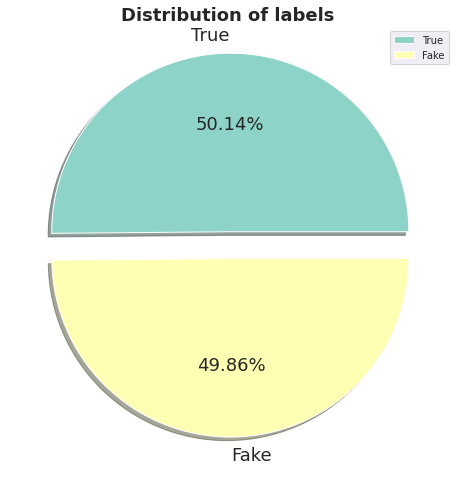

In [12]:
counts = data['label'].value_counts()
mylabels = ["True", "Fake"]
text_font = {"fontsize":18}
explode = [0.1,0.05]
plt.figure(figsize=(8,12))
plt.pie(counts, labels = mylabels,autopct = "%0.2f%%",colors=['#8dd3c7','#feffb3'],explode = explode,textprops =text_font,shadow = True)
plt.title('Distribution of labels ',size=18,fontweight = 'bold')
plt.legend()
plt.show() 

In [13]:
def clean_text(text):
    """The function removes punctuation marks, stop words, links, words
     with numbers inside and converts the string to lowercase.
    Args: 
        text: input string.
    Returns:
        string.
    """
    text = str(text).lower()
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('\w*\d\w*', '', text) 

    emoji_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    text = emoji_pattern.sub(r'',text)
  
    stop_word = stopwords.words('spanish') 
    
    wo_punc = [letter for letter in text if letter not in string.punctuation+str('“”—·…¡¡¡�¡⭕♦✔️◀🧵✍️«»')]
    wo_punc = ''.join(wo_punc)
    wo_stop_word = [word for word in wo_punc.split() if word not in stop_word]
    result = ' '.join(wo_stop_word)
    return result    

In [14]:
data['clean_text'] = data['text'].apply(clean_text)

In [15]:
stemmer = PorterStemmer() #SnowballStemmer('spanish')
def stemming_text(text):
  stemmed_text = [stemmer.stem(i) for i in word_tokenize(text)]
  result = ' '.join(stemmed_text)
  return result

In [16]:
data['stemm_text'] = data['clean_text'].apply(stemming_text)

In [17]:
lemma = WordNetLemmatizer()
def lemma_text(text):
  lemma_text = [lemma.lemmatize(i) for i in word_tokenize(text)]
  result = ' '.join(lemma_text)
  return result

In [18]:
data['lemm_text'] = data['clean_text'].apply(lemma_text)

In [19]:
data.head(3)

,text,label,clean_text,stemm_text,lemm_text
0,"Pedro Martín-Barrajón: ""El suicidio es un prob...",1,pedro martínbarrajón suicidio problema salud p...,pedro martínbarrajón suicidio problema salud p...,pedro martínbarrajón suicidio problema salud p...
1,EN CAMISA DE ONCE VARAS (XVII)Fernando Esteso...,1,camisa once varas xviifernando esteso destape ...,camisa onc vara xviifernando esteso destap ino...,camisa once vara xviifernando esteso destape i...
2,"""La violación es un crimen, pero un flirteo t...",1,violación crimen flirteo tenaz delito galanter...,violación crimen flirteo tenaz delito galanter...,violación crimen flirteo tenaz delito galanter...


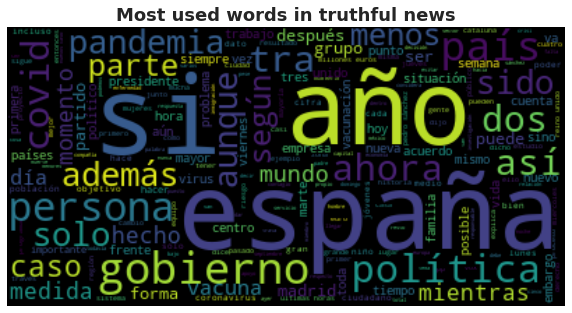

In [22]:
wordcloud_true = WordCloud().generate(' '.join(data[data['label']==1]['clean_text']))

plt.figure(figsize=(10,15))
plt.imshow(wordcloud_true, interpolation='bilinear')
plt.axis("off")
plt.title('Most used words in truthful news',size=18,fontweight = 'bold')
plt.show()

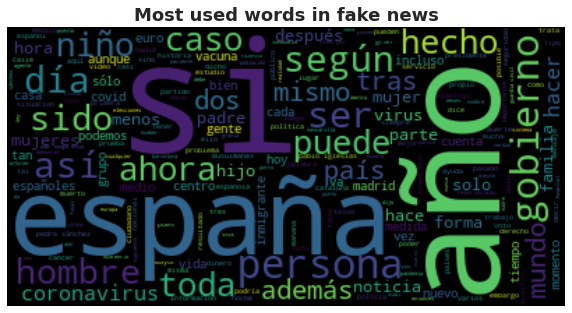

In [23]:
wordcloud_fake = WordCloud().generate(' '.join(data[data['label']==0]['clean_text']))

plt.figure(figsize=(10,15))
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.axis("off")
plt.title('Most used words in fake news',size=18,fontweight = 'bold')
plt.show()

# Train test split

In [24]:
X_train, X_val, y_train, y_val = train_test_split(data.drop('label',axis=1), data['label'], test_size=0.2, random_state=42,stratify=data['label'])

In [25]:
print('Train',X_train.shape[0])
print('Val',X_val.shape[0])

Train 4146
Val 1037


# Tf-idf ML


In [26]:
tf = TfidfVectorizer()
tf.fit(X_train['lemm_text'])
X_train_tf = tf.transform(X_train['lemm_text'])
X_val_tf = tf.transform(X_val['lemm_text'])

In [27]:
print(X_train_tf.shape)
print(X_val_tf.shape)

(4146, 52504)
(1037, 52504)


In [28]:
models = []
models.append(('KNN', KNeighborsClassifier()))
models.append(('SVM', SVC()))
models.append(('Tree', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))    
models.append(('ABoost', AdaBoostClassifier()))
models.append(('GBoost', GradientBoostingClassifier()))
models.append(('LogReg', LogisticRegression()))
models.append(('NaivB', MultinomialNB()))


In [29]:
cm_list = []

print('Model\tAcc\tPr\tRecall\tF1\tTime')      

for name, alg in models:
    start_time = time.time()
    model = alg.fit(X_train_tf,y_train)
    delta = time.time() - start_time

    accuracy =accuracy_score(y_val, model.predict(X_val_tf))
    recall = recall_score(y_val, model.predict(X_val_tf))
    precision = precision_score(y_val, model.predict(X_val_tf))
    f_score = f1_score(y_val, model.predict(X_val_tf))

    cm_list.append((name, model.predict(X_val_tf)))
    
    print('{}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.2f} secs'.format(name, accuracy, precision, recall, f_score, delta))

Model	Acc	Pr	Recall	F1	Time
KNN	0.770	0.741	0.835	0.785	0.01 secs
SVM	0.887	0.921	0.848	0.883	9.83 secs
Tree	0.794	0.789	0.804	0.796	3.04 secs
RF	0.861	0.888	0.827	0.857	7.95 secs
ABoost	0.834	0.849	0.813	0.831	3.50 secs
GBoost	0.857	0.887	0.819	0.852	14.25 secs
LogReg	0.878	0.899	0.852	0.875	0.58 secs
NaivB	0.753	0.678	0.967	0.797	0.01 secs


In [138]:
def conf_matrix(cm,title=''):
    plt.figure(figsize=(10,6))
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax,annot_kws={"size": 15},cmap="YlGnBu"); 
    
    ax.set_xlabel('Predicted',size=15);
    ax.set_ylabel('True',size=15); 
    ax.set_title('Confusion Matrix '+ title,size=18); 
    ax.xaxis.set_ticklabels(['fake', 'true'],size=15);
    ax.yaxis.set_ticklabels(['fake', 'true'],size=15);
    plt.show()

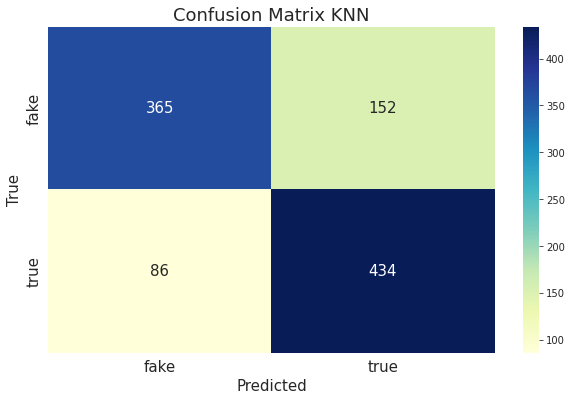

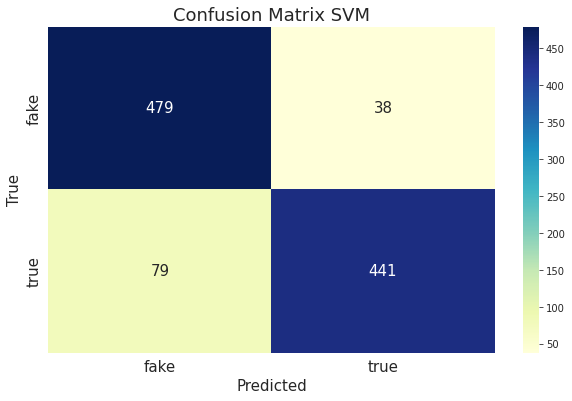

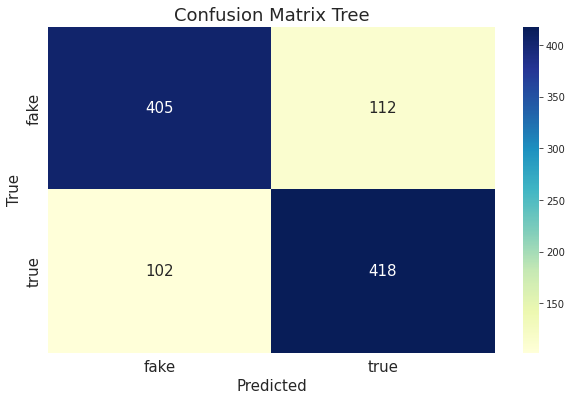

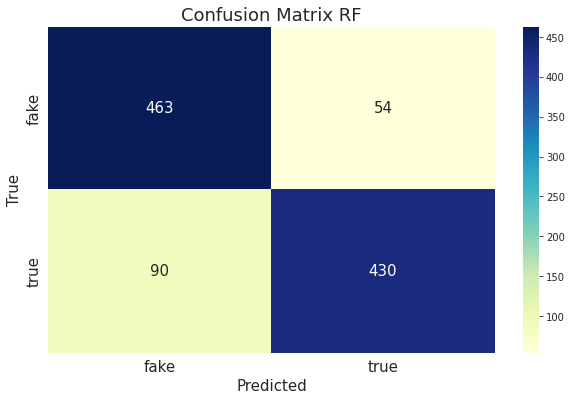

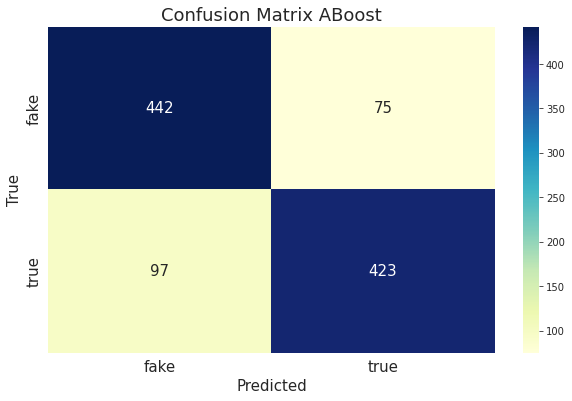

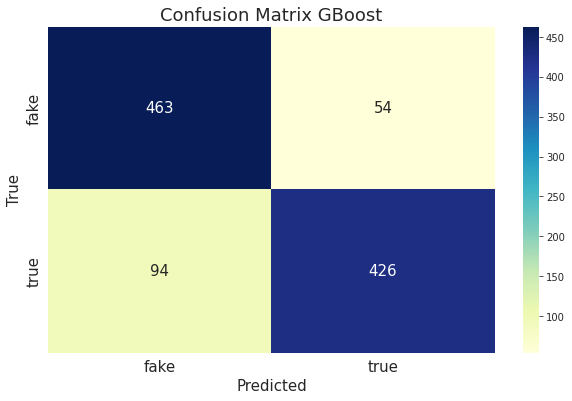

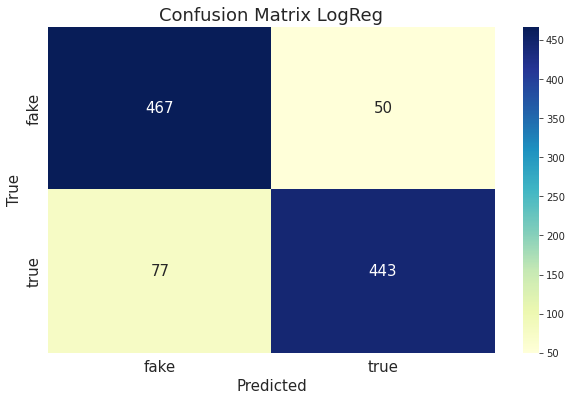

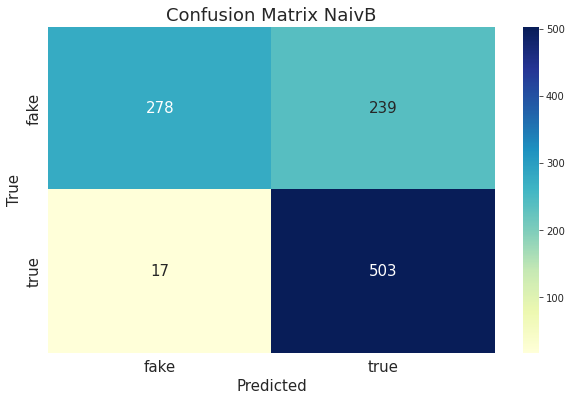

In [31]:
for title_mdl,mdl in cm_list:
  conf_mat = confusion_matrix(y_val,mdl)
  conf_matrix(cm=conf_mat,title=str(title_mdl))
  print('\n')

In [32]:
def error_analysis(real,predict):
  error_pred = []
  error_real = []
  error_text = []
  for pred,real,index in zip(predict,real,range(len(real))): 
    if pred != real:

      error_pred.append(pred)
      error_real.append(real)
      error_text.append(X_val.reset_index(drop=True).loc[index,'text'])
  error_df = pd.DataFrame({'text':error_text,'prediction':error_pred,'real':error_real})
  return error_df

In [33]:
error_analysis(y_val,cm_list[1][1]) #SVM errors

,text,prediction,real
0,"El dueño de Amazon: ""El libro de Cristina ser...",1,0
1,"Columna | ""Iván Zhdanov dirigió la Fundación ...",0,1
2,Buscan al enmascarado que mató de un machetaz...,0,1
3,"Una de historia, la sucesión dinástica desde ...",0,1
4,Puerto Rico pide ayuda a la comunidad internac...,1,0
...,...,...,...
112,El Parlamento Europeo condena el Comunismo y e...,1,0
113,"Miguel Rellán: ""Tuve una neumonía bilateral de...",0,1
114,Tres detenidos en Canarias por secuestrar a un...,0,1
115,EDITORIAL | Si la Comunidad de Madrid permane...,0,1


# Tokenization


In [34]:
MAX_SEQUENCE_LENGTH = 500  
min_count = 5
EMBEDDING_DIM = 300

In [35]:
features_train = list(X_train['lemm_text'])
labels_train = np.asarray(y_train)

features_val = list(X_val['lemm_text'])
labels_val = np.asarray(y_val)


In [36]:
token_counts = Counter()

In [37]:
for _, row in X_train[['lemm_text']].iterrows():
    for text in row:
        token_counts.update(text.split(" "))

In [38]:
print("All tokens from train:",len(token_counts))\

All tokens from train: 52871


In [39]:
# Take tokens that frquency >5
min_count = 5
tokens = [token for token, count in token_counts.items() if count >= min_count]

In [40]:
PAD, UNK = "PAD","UNK"
tokens = [PAD,UNK] + sorted(tokens)
print("Vocabulary size:", len(tokens))

Vocabulary size: 14300


In [41]:
token_to_id = {token: idx for idx, token in enumerate(tokens)} #dictionary

In [42]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """Convert a list of tokens into a matrix with padding"""
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))

    max_len = min(max(map(len, sequences)), max_len or float("inf"))

    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i, seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, : len(row_ix)] = row_ix

    return matrix

In [43]:
data_train = as_matrix(X_train['lemm_text'].values,max_len=MAX_SEQUENCE_LENGTH)
data_val = as_matrix(X_val['lemm_text'].values,max_len=MAX_SEQUENCE_LENGTH)

In [44]:
data_train[0:3]

array([[10176,  6390,  9365, ...,     0,     0,     0],
       [14246, 13797,  5045, ...,     0,     0,     0],
       [12432,  9917,  9982, ...,     0,     0,     0]], dtype=int32)

In [45]:
embeddings_index = {}
f = open('/content/drive/MyDrive/data/SBW-vectors-300-min5.txt',encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [46]:
del embeddings_index['1000653']

In [47]:
embedding_matrix =  np.random.normal(scale = 0.06,size=(len(token_to_id) + 1, EMBEDDING_DIM)) #np.random.random
cnt=0
for word, i in token_to_id.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
      cnt +=1


embedding_layer = Embedding(len(token_to_id) + 1,
                            EMBEDDING_DIM,weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,trainable=True)

In [48]:
print('Number of words not found in corpus:',cnt)

Number of words not found in corpus: 777


# CNN



In [49]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13231188503270373724
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11320098816
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5697292316577466463
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
xla_global_id: 416903419
]


In [50]:
del model 

In [51]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_cov1= Conv1D(filters=128, kernel_size=10, strides=2, padding='same', activation='relu')(embedded_sequences)
l_pool1 = MaxPooling1D(5)(l_cov1)
#l_cov2 = Conv1D(filters=128, kernel_size=5, strides=2, padding='same', activation='relu')(l_pool1)
#l_pool2 = MaxPooling1D(5)(l_cov2)
#l_cov3 = Conv1D(128, 5, activation='relu')(l_pool2)
#l_pool3 = MaxPooling1D(5)(l_cov3)  
l_flat = Flatten()(l_pool1)
l_dense = Dense(128, activation='relu')(l_flat)
dropout = Dropout(0.5)(l_dense)
preds = Dense(1, activation='sigmoid')(dropout)

model = Model(sequence_input, preds)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

model.summary()
cp=ModelCheckpoint('model_cnn.hdf5',monitor='val_acc',verbose=1,save_best_only=True)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500)]             0         
                                                                 
 embedding (Embedding)       (None, 500, 300)          4290300   
                                                                 
 conv1d (Conv1D)             (None, 250, 128)          384128    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 50, 128)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 6400)              0         
                                                                 
 dense (Dense)               (None, 128)               819328    
                                                             

In [52]:
history=model.fit(data_train, labels_train, validation_data=(data_val, labels_val),epochs=5, batch_size=64,callbacks=[cp])

Epoch 1/5
65/65 [==============================] - ETA: 0s - loss: 0.5764 - acc: 0.6681
Epoch 00001: val_acc improved from -inf to 0.65381, saving model to model_cnn.hdf5
65/65 [==============================] - 35s 60ms/step - loss: 0.5764 - acc: 0.6681 - val_loss: 0.5566 - val_acc: 0.6538
Epoch 2/5
65/65 [==============================] - ETA: 0s - loss: 0.3411 - acc: 0.8594
Epoch 00002: val_acc improved from 0.65381 to 0.87175, saving model to model_cnn.hdf5
65/65 [==============================] - 3s 53ms/step - loss: 0.3411 - acc: 0.8594 - val_loss: 0.3108 - val_acc: 0.8717
Epoch 3/5
65/65 [==============================] - ETA: 0s - loss: 0.0609 - acc: 0.9817
Epoch 00003: val_acc improved from 0.87175 to 0.87367, saving model to model_cnn.hdf5
65/65 [==============================] - 4s 55ms/step - loss: 0.0609 - acc: 0.9817 - val_loss: 0.3786 - val_acc: 0.8737
Epoch 4/5
64/65 [============================>.] - ETA: 0s - loss: 0.0114 - acc: 0.9990
Epoch 00004: val_acc did not imp

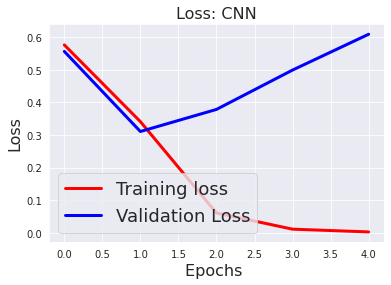

In [53]:
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss: CNN',fontsize=16)
plt.show()

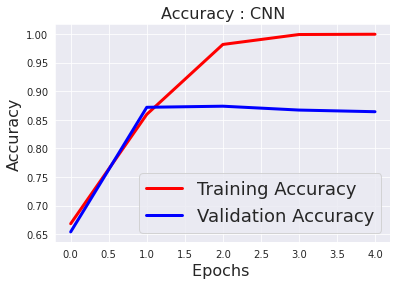

In [54]:
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy : CNN',fontsize=16)
plt.show()

In [55]:
model.load_weights('model_cnn.hdf5')

In [56]:
predict_val = np.where(model.predict(data_val).reshape(-1,) >= 0.5, 1, 0) 

In [57]:
print('accuracy',accuracy_score(labels_val,predict_val))
print('recall',recall_score(labels_val,predict_val))
print('precision',precision_score(labels_val,predict_val))
print('F-score',f1_score(labels_val,predict_val))

accuracy 0.8736740597878495
recall 0.8730769230769231
precision 0.8747591522157996
F-score 0.873917228103946


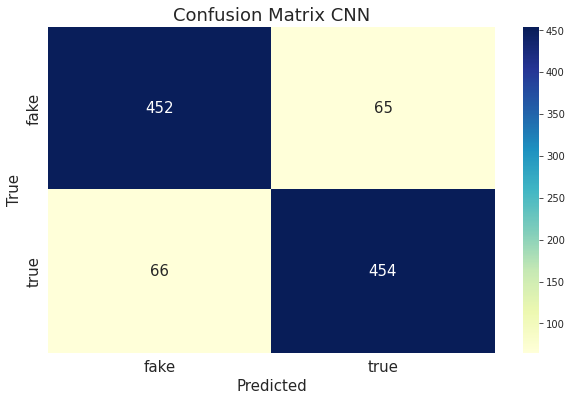

In [58]:
conf_matrix(cm=confusion_matrix(labels_val,predict_val),title='CNN')

In [59]:
error_analysis(labels_val,predict_val)

,text,prediction,real
0,"Jorge Perugorría: ""El glamour de Cuba ya no ex...",0,1
1,"«Hubo personas que fueron fusiladas, pero con...",1,0
2,Buscan al enmascarado que mató de un machetaz...,0,1
3,Galicia suspende las clases presenciales de Fo...,1,0
4,"Una de historia, la sucesión dinástica desde ...",0,1
...,...,...,...
126,"""Hoy mismo llamaré a Pablo Casado y Albert Ri...",0,1
127,"Españoles, alerta, la empresa que procesará la...",1,0
128,El Parlamento Europeo condena el Comunismo y e...,1,0
129,"Miguel Rellán: ""Tuve una neumonía bilateral de...",0,1


In [60]:
del model

# RNN

In [61]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_lstm = Bidirectional(LSTM(100))(embedded_sequences)
preds = Dense(1, activation='sigmoid')(l_lstm)
model = Model(sequence_input, preds)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

print("Bidirectional LSTM")
model.summary()
cp=ModelCheckpoint('model_rnn.hdf5',monitor='val_acc',verbose=1,save_best_only=True)

Bidirectional LSTM
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 500)]             0         
                                                                 
 embedding (Embedding)       (None, 500, 300)          4290300   
                                                                 
 bidirectional (Bidirectiona  (None, 200)              320800    
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 1)                 201       
                                                                 
Total params: 4,611,301
Trainable params: 4,611,301
Non-trainable params: 0
_________________________________________________________________


In [62]:
history=model.fit(data_train, labels_train, validation_data=(data_val, labels_val),epochs=5, batch_size=64,callbacks=[cp])

Epoch 1/5
33/33 [==============================] - ETA: 0s - loss: 0.4558 - acc: 0.8331
Epoch 00001: val_acc improved from -inf to 0.79942, saving model to model_rnn.hdf5
33/33 [==============================] - 14s 300ms/step - loss: 0.4558 - acc: 0.8331 - val_loss: 0.4650 - val_acc: 0.7994
Epoch 2/5
33/33 [==============================] - ETA: 0s - loss: 0.1499 - acc: 0.9561
Epoch 00002: val_acc improved from 0.79942 to 0.84764, saving model to model_rnn.hdf5
33/33 [==============================] - 9s 268ms/step - loss: 0.1499 - acc: 0.9561 - val_loss: 0.3555 - val_acc: 0.8476
Epoch 3/5
33/33 [==============================] - ETA: 0s - loss: 0.0528 - acc: 0.9884
Epoch 00003: val_acc improved from 0.84764 to 0.85342, saving model to model_rnn.hdf5
33/33 [==============================] - 9s 267ms/step - loss: 0.0528 - acc: 0.9884 - val_loss: 0.4127 - val_acc: 0.8534
Epoch 4/5
33/33 [==============================] - ETA: 0s - loss: 0.0211 - acc: 0.9969
Epoch 00004: val_acc did not 

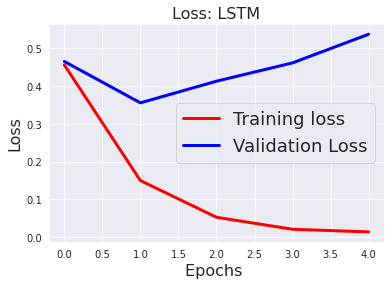

In [63]:
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss: LSTM',fontsize=16)
plt.show()

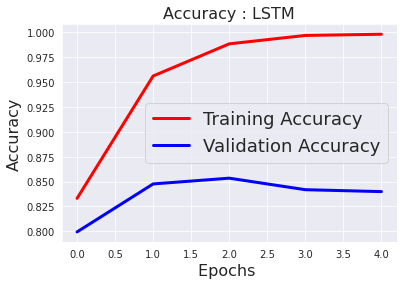

In [64]:
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy : LSTM',fontsize=16)
plt.show()

In [65]:
model.load_weights('model_rnn.hdf5')
predict_val = np.where(model.predict(data_val).reshape(-1,) >= 0.5, 1, 0) 

In [66]:
print('accuracy',accuracy_score(labels_val,predict_val))
print('recall',recall_score(labels_val,predict_val))
print('precision',precision_score(labels_val,predict_val))
print('F-score',f1_score(labels_val,predict_val))

accuracy 0.8534233365477338
recall 0.8788461538461538
precision 0.836996336996337
F-score 0.8574108818011257


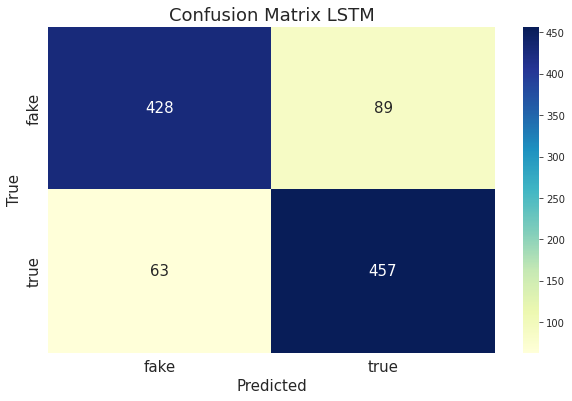

In [67]:
conf_matrix(cm=confusion_matrix(labels_val,predict_val),title='LSTM')

In [68]:
error_analysis(labels_val,predict_val)

,text,prediction,real
0,"El dueño de Amazon: ""El libro de Cristina ser...",1,0
1,"Si juego siempre el mismo número, alguna vez ...",1,0
2,"«Hubo personas que fueron fusiladas, pero con...",1,0
3,Buscan al enmascarado que mató de un machetaz...,0,1
4,Galicia suspende las clases presenciales de Fo...,1,0
...,...,...,...
147,Pedro Sánchez lleva a los españoles a la ruin...,1,0
148,Fallece por Covid una mujer en Alicante tras ...,0,1
149,El Parlamento Europeo condena el Comunismo y e...,1,0
150,EL USO COMPULSIVO DE MASCARILLAS OCASIONA LA P...,1,0


In [69]:
del model

# CNN + RNN



In [70]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_cov1= Conv1D(filters=100, kernel_size=10, strides=2, padding='same', activation='relu')(embedded_sequences)
l_pool1 = MaxPooling1D(10)(l_cov1)
l_lstm = Bidirectional(LSTM(50))(l_cov1)  
l_flat = Flatten()(l_lstm)
l_dense = Dense(100, activation='relu')(l_flat)
dropout = Dropout(0.5)(l_dense)
preds = Dense(1, activation='sigmoid')(dropout)

model = Model(sequence_input, preds)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

model.summary()
cp=ModelCheckpoint('model_cnn_rnn.hdf5',monitor='val_acc',verbose=1,save_best_only=True)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 500)]             0         
                                                                 
 embedding (Embedding)       (None, 500, 300)          4290300   
                                                                 
 conv1d_1 (Conv1D)           (None, 250, 100)          300100    
                                                                 
 bidirectional_1 (Bidirectio  (None, 100)              60400     
 nal)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 100)               10100     
                                                           

In [71]:
history=model.fit(data_train, labels_train, validation_data=(data_val, labels_val),epochs=5, batch_size=64,callbacks=[cp])

Epoch 1/5
65/65 [==============================] - ETA: 0s - loss: 0.1522 - acc: 0.9551
Epoch 00001: val_acc improved from -inf to 0.84185, saving model to model_cnn_rnn.hdf5
65/65 [==============================] - 14s 146ms/step - loss: 0.1522 - acc: 0.9551 - val_loss: 0.6167 - val_acc: 0.8419
Epoch 2/5
65/65 [==============================] - ETA: 0s - loss: 0.0152 - acc: 0.9957
Epoch 00002: val_acc improved from 0.84185 to 0.85535, saving model to model_cnn_rnn.hdf5
65/65 [==============================] - 8s 121ms/step - loss: 0.0152 - acc: 0.9957 - val_loss: 0.6439 - val_acc: 0.8554
Epoch 3/5
65/65 [==============================] - ETA: 0s - loss: 0.0051 - acc: 0.9995
Epoch 00003: val_acc did not improve from 0.85535
65/65 [==============================] - 8s 119ms/step - loss: 0.0051 - acc: 0.9995 - val_loss: 0.7577 - val_acc: 0.8534
Epoch 4/5
65/65 [==============================] - ETA: 0s - loss: 0.0045 - acc: 0.9993
Epoch 00004: val_acc improved from 0.85535 to 0.85632, sa

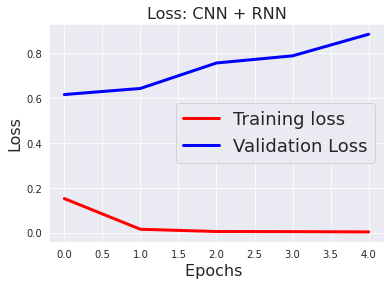

In [72]:
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss: CNN + RNN',fontsize=16)
plt.show()

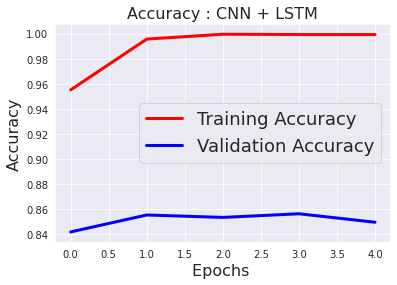

In [73]:
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy : CNN + LSTM',fontsize=16)
plt.show()

In [74]:
model.load_weights('model_cnn_rnn.hdf5')
predict_val = np.where(model.predict(data_val).reshape(-1,) >= 0.5, 1, 0) 

In [75]:
print('accuracy',accuracy_score(labels_val,predict_val))
print('recall',recall_score(labels_val,predict_val))
print('precision',precision_score(labels_val,predict_val))
print('F-score',f1_score(labels_val,predict_val))

accuracy 0.8563162970106075
recall 0.8596153846153847
precision 0.8546845124282982
F-score 0.8571428571428572


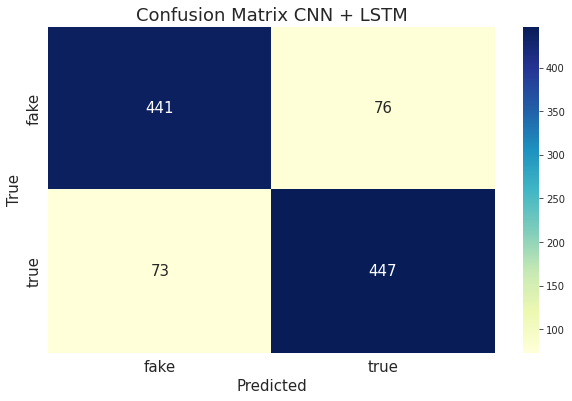

In [76]:
conf_matrix(cm=confusion_matrix(labels_val,predict_val),title='CNN + LSTM')

In [77]:
error_analysis(labels_val,predict_val)

,text,prediction,real
0,"El dueño de Amazon: ""El libro de Cristina ser...",1,0
1,"Si juego siempre el mismo número, alguna vez ...",1,0
2,"«Hubo personas que fueron fusiladas, pero con...",1,0
3,Navarra a punto de conseguir su propia vacuna...,0,1
4,Buscan al enmascarado que mató de un machetaz...,0,1
...,...,...,...
144,"Parroquia de San Agustín de El Ejido, Almería...",1,0
145,Hay maestros que enseñan Religión con el 'Min...,0,1
146,Pedro Sánchez lleva a los españoles a la ruin...,1,0
147,Fallece por Covid una mujer en Alicante tras ...,0,1


# BERT

In [20]:
tokenizer = BertTokenizer.from_pretrained("pytorch/", do_lower_case=True)
model = BertModel.from_pretrained("pytorch/")
#e = model.eval()

Some weights of the model checkpoint at pytorch/ were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [24]:
tokenized = data['lemm_text'].apply((lambda x: tokenizer.encode(x,max_length=300, add_special_tokens=True)))

In [25]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
padded.shape

(5183, 300)

In [26]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(5183, 300)

In [ ]:
device = torch.device("cuda:0")
model.to(device)

In [83]:
import tqdm

In [84]:
output = []
batch_size = 64
for idx in tqdm.tnrange(0, 5183, batch_size):
  batch = torch.tensor(padded[idx: idx+batch_size]).to(device)
  local_attention_mask = torch.tensor(attention_mask[idx:idx+batch_size]).to(device)

  with torch.no_grad():
    last_hidden_states = model(batch, attention_mask=local_attention_mask) [0] [:,0,:].cpu().numpy()
    output.append(last_hidden_states)

  0%|          | 0/81 [00:00<?, ?it/s]

In [85]:
feature_after_bert = np.vstack(output)

In [27]:
labels = data['label']

In [86]:
print(feature_after_bert.shape)
print(labels.shape)

(5183, 768)
(5183,)


In [87]:
train_features, val_features, train_labels, val_labels = train_test_split(feature_after_bert, labels, test_size=0.2, random_state=42,stratify=labels)

In [88]:
print('Train',train_features.shape[0])
print('Val',val_features.shape[0])

Train 4146
Val 1037


In [89]:
lr_clf = LogisticRegression()
lr_clf.fit(train_features, train_labels)

LogisticRegression()

In [90]:
predict_val = lr_clf.predict(val_features)

In [91]:
print('accuracy',accuracy_score(labels_val,predict_val))
print('recall',recall_score(labels_val,predict_val))
print('precision',precision_score(labels_val,predict_val))
print('F-score',f1_score(labels_val,predict_val))

accuracy 0.7868852459016393
recall 0.7711538461538462
precision 0.7972166998011928
F-score 0.7839687194525905


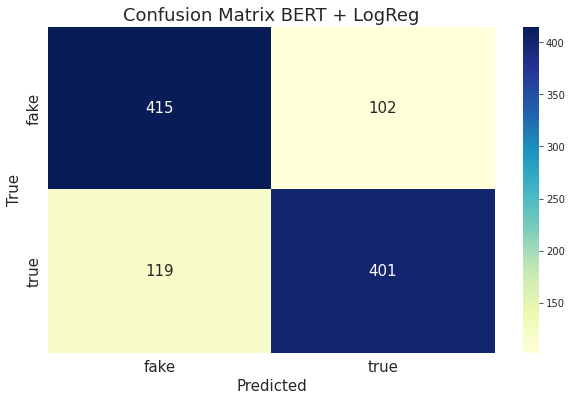

In [93]:
conf_matrix(cm=confusion_matrix(val_labels, predict_val),title='BERT + LogReg')

In [94]:
error_analysis(labels_val,predict_val)

,text,prediction,real
0,El poder estuvo activo hasta 2015. El alcalde...,0,1
1,¿Qué es el financiamiento verde? Como una res...,0,1
2,"El dueño de Amazon: ""El libro de Cristina ser...",1,0
3,"“Por primera vez en su historia, Irán sube la...",1,0
4,El glaseado que camufla al coronavirus Los az...,0,1
...,...,...,...
216,El Parlamento Europeo condena el Comunismo y e...,1,0
217,…quiere auditar en el Congreso la política de...,0,1
218,"Miguel Rellán: ""Tuve una neumonía bilateral de...",0,1
219,Tres detenidos en Canarias por secuestrar a un...,0,1


# BERT + CNN

In [99]:
sequence_input = Input(shape=(train_features.shape[1],1)) #Input(shape = (train_features.shape,1,)
#embedded_sequences = Embedding()(sequence_input)
l_cov1= Conv1D(filters=128, kernel_size=10, strides=2, padding='same', activation='relu')(sequence_input)
l_pool1 = MaxPooling1D(5)(l_cov1)
#l_cov2 = Conv1D(filters=128, kernel_size=5, strides=2, padding='same', activation='relu')(l_pool1)
#l_pool2 = MaxPooling1D(5)(l_cov2)
#l_cov3 = Conv1D(128, 5, activation='relu')(l_pool2)
#l_pool3 = MaxPooling1D(5)(l_cov3)  
l_flat = Flatten()(l_pool1)
l_dense = Dense(128, activation='relu')(l_flat)
dropout = Dropout(0.5)(l_dense)
preds = Dense(1, activation='sigmoid')(dropout)

model = Model(sequence_input, preds)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

model.summary()
cp=ModelCheckpoint('model_cnn_bert.hdf5',monitor='val_acc',verbose=1,save_best_only=True)

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 768, 1)]          0         
                                                                 
 conv1d_4 (Conv1D)           (None, 384, 128)          1408      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 76, 128)          0         
 1D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 9728)              0         
                                                                 
 dense_9 (Dense)             (None, 128)               1245312   
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                           

In [100]:
history=model.fit(train_features, train_labels, validation_data=(val_features, val_labels),epochs=10, batch_size=16,callbacks=[cp]) 

Epoch 1/10
255/260 [============================>.] - ETA: 0s - loss: 0.5861 - acc: 0.6924
Epoch 00001: val_acc improved from -inf to 0.76953, saving model to model_cnn_bert.hdf5
260/260 [==============================] - 3s 8ms/step - loss: 0.5854 - acc: 0.6930 - val_loss: 0.5130 - val_acc: 0.7695
Epoch 2/10
257/260 [============================>.] - ETA: 0s - loss: 0.5027 - acc: 0.7517
Epoch 00002: val_acc improved from 0.76953 to 0.78206, saving model to model_cnn_bert.hdf5
260/260 [==============================] - 2s 8ms/step - loss: 0.5032 - acc: 0.7516 - val_loss: 0.4777 - val_acc: 0.7821
Epoch 3/10
253/260 [============================>.] - ETA: 0s - loss: 0.4626 - acc: 0.7824
Epoch 00003: val_acc improved from 0.78206 to 0.78881, saving model to model_cnn_bert.hdf5
260/260 [==============================] - 2s 8ms/step - loss: 0.4640 - acc: 0.7815 - val_loss: 0.4513 - val_acc: 0.7888
Epoch 4/10
259/260 [============================>.] - ETA: 0s - loss: 0.4339 - acc: 0.8021
Epo

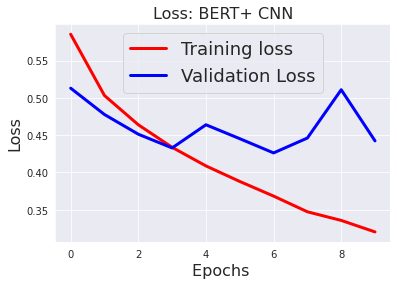

In [101]:
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss: BERT+ CNN',fontsize=16)
plt.show()

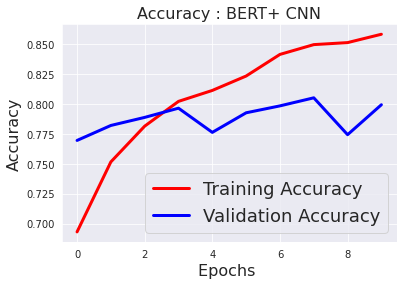

In [102]:
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy : BERT+ CNN',fontsize=16)
plt.show()

In [104]:
model.load_weights('model_cnn_bert.hdf5')
predict_val = np.where(model.predict(val_features).reshape(-1,) >= 0.5, 1, 0) 

In [105]:
print('accuracy',accuracy_score(labels_val,predict_val))
print('recall',recall_score(labels_val,predict_val))
print('precision',precision_score(labels_val,predict_val))
print('F-score',f1_score(labels_val,predict_val))

accuracy 0.8052073288331726
recall 0.8153846153846154
precision 0.8
F-score 0.8076190476190477


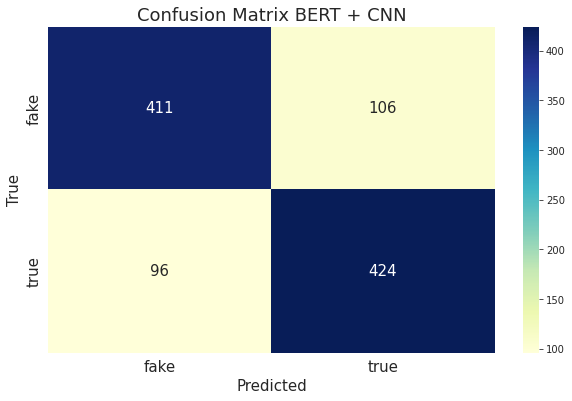

In [106]:
conf_matrix(cm=confusion_matrix(labels_val,predict_val),title='BERT + CNN')

In [107]:
error_analysis(labels_val,predict_val)

,text,prediction,real
0,¿Qué es el financiamiento verde? Como una res...,0,1
1,"Jorge Perugorría: ""El glamour de Cuba ya no ex...",0,1
2,"«Hubo personas que fueron fusiladas, pero con...",1,0
3,Navarra a punto de conseguir su propia vacuna...,0,1
4,Buscan al enmascarado que mató de un machetaz...,0,1
...,...,...,...
197,El Parlamento Europeo condena el Comunismo y e...,1,0
198,EL USO COMPULSIVO DE MASCARILLAS OCASIONA LA P...,1,0
199,"Miguel Rellán: ""Tuve una neumonía bilateral de...",0,1
200,Tres detenidos en Canarias por secuestrar a un...,0,1


# BERT + LSTM

In [111]:
del model

In [112]:
sequence_input = Input(shape=(train_features.shape[1],1)) #Input(shape = (train_features.shape,1,)

l_lstm = Bidirectional(LSTM(200))(sequence_input)
preds = Dense(1, activation='sigmoid')(l_lstm)
model = Model(sequence_input, preds)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

print("Bidirectional LSTM")
model.summary()
cp=ModelCheckpoint('model_rnn_bert.hdf5',monitor='val_acc',verbose=1,save_best_only=True)

Bidirectional LSTM
Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 768, 1)]          0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 400)              323200    
 nal)                                                            
                                                                 
 dense_12 (Dense)            (None, 1)                 401       
                                                                 
Total params: 323,601
Trainable params: 323,601
Non-trainable params: 0
_________________________________________________________________


In [113]:
history=model.fit(train_features, train_labels, validation_data=(val_features, val_labels),epochs=10, batch_size=16,callbacks=[cp])

Epoch 1/10
260/260 [==============================] - ETA: 0s - loss: 0.6275 - acc: 0.6259
Epoch 00001: val_acc improved from -inf to 0.63838, saving model to model_rnn_bert.hdf5
260/260 [==============================] - 83s 307ms/step - loss: 0.6275 - acc: 0.6259 - val_loss: 0.6379 - val_acc: 0.6384
Epoch 2/10
260/260 [==============================] - ETA: 0s - loss: 0.5981 - acc: 0.6712
Epoch 00002: val_acc improved from 0.63838 to 0.64899, saving model to model_rnn_bert.hdf5
260/260 [==============================] - 79s 304ms/step - loss: 0.5981 - acc: 0.6712 - val_loss: 0.6040 - val_acc: 0.6490
Epoch 3/10
260/260 [==============================] - ETA: 0s - loss: 0.5835 - acc: 0.6807
Epoch 00003: val_acc improved from 0.64899 to 0.67020, saving model to model_rnn_bert.hdf5
260/260 [==============================] - 79s 304ms/step - loss: 0.5835 - acc: 0.6807 - val_loss: 0.5981 - val_acc: 0.6702
Epoch 4/10
260/260 [==============================] - ETA: 0s - loss: 0.5819 - acc: 0

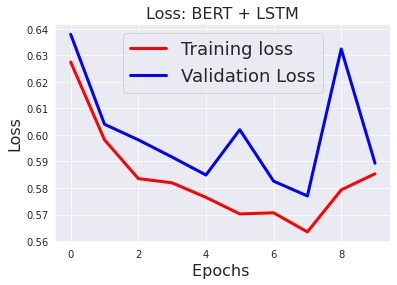

In [114]:
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss: BERT + LSTM',fontsize=16)
plt.show()

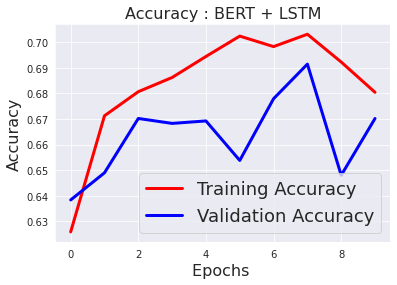

In [115]:
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy : BERT + LSTM',fontsize=16)
plt.show()

In [116]:
model.load_weights('model_rnn_bert.hdf5')
predict_val = np.where(model.predict(val_features).reshape(-1,) >= 0.5, 1, 0) 

In [117]:
print('accuracy',accuracy_score(labels_val,predict_val))
print('recall',recall_score(labels_val,predict_val))
print('precision',precision_score(labels_val,predict_val))
print('F-score',f1_score(labels_val,predict_val))

accuracy 0.6914175506268081
recall 0.6653846153846154
precision 0.7032520325203252
F-score 0.683794466403162


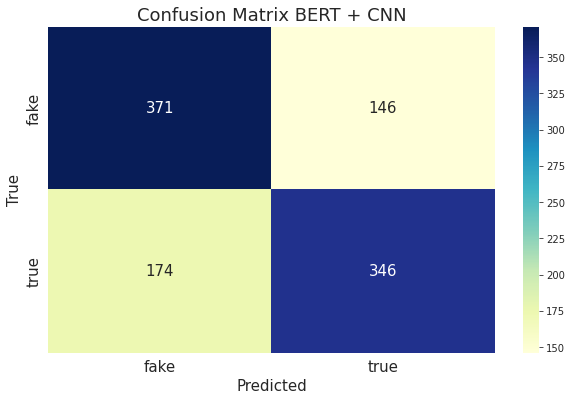

In [118]:
conf_matrix(cm=confusion_matrix(labels_val,predict_val),title='BERT + CNN')

In [119]:
error_analysis(labels_val,predict_val)

,text,prediction,real
0,Аmpliado el permiso retribuido 30 días despué...,1,0
1,El poder estuvo activo hasta 2015. El alcalde...,0,1
2,Cuando la política se convierte en circo Pie...,0,1
3,"Jorge Perugorría: ""El glamour de Cuba ya no ex...",0,1
4,"La palabra “haiga”, aceptada por la RAE La Rea...",1,0
...,...,...,...
315,EL USO COMPULSIVO DE MASCARILLAS OCASIONA LA P...,1,0
316,"Miguel Rellán: ""Tuve una neumonía bilateral de...",0,1
317,Tres detenidos en Canarias por secuestrar a un...,0,1
318,EDITORIAL | Si la Comunidad de Madrid permane...,0,1


# BertForSequenceClassification

In [39]:
torch.cuda.empty_cache()

In [28]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
input_ids = torch.from_numpy(padded)
attention_masks = torch.from_numpy(attention_mask)
labels = torch.tensor(list(labels))

dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 80-20 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size


# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

4,146 training samples
1,037 validation samples


In [29]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 16

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [30]:
model = BertForSequenceClassification.from_pretrained("pytorch/",num_labels = 2)
model.cuda()

Some weights of the model checkpoint at pytorch/ were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at pytorch/

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31002, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [31]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, 
                  eps = 1e-8 
                )


In [32]:
from transformers import get_linear_schedule_with_warmup

epochs = 4

total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

In [33]:
# Function to calculate the accuracy of our predictions vs labels
import time
import datetime

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [34]:
device = torch.device("cuda")

In [35]:
import random
import numpy as np

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        
        model.zero_grad()        

        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model. The "logits" are the 
        # output values prior to applying an activation function like the 
        # softmax.
        loss = result.loss
        logits = result.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.3f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    260.    Elapsed: 0:01:08.
  Batch    80  of    260.    Elapsed: 0:02:15.
  Batch   120  of    260.    Elapsed: 0:03:23.
  Batch   160  of    260.    Elapsed: 0:04:30.
  Batch   200  of    260.    Elapsed: 0:05:37.
  Batch   240  of    260.    Elapsed: 0:06:44.

  Average training loss: 0.44
  Training epcoh took: 0:07:16

Running Validation...
  Accuracy: 0.87
  Validation Loss: 0.32
  Validation took: 0:00:42

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    260.    Elapsed: 0:01:07.
  Batch    80  of    260.    Elapsed: 0:02:14.
  Batch   120  of    260.    Elapsed: 0:03:21.
  Batch   160  of    260.    Elapsed: 0:04:28.
  Batch   200  of    260.    Elapsed: 0:05:35.
  Batch   240  of    260.    Elapsed: 0:06:42.

  Average training loss: 0.21
  Training epcoh took: 0:07:14

Running Validation...
  Accuracy: 0.86
  Validation Loss: 0.36
  Validation took: 0:00:42

======== Epoch 3 / 4 ========
Training...
 

In [132]:
# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in validation_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

    DONE.


In [133]:
real_label = []

In [134]:
predicted_label = np.where(np.vstack(np.array(predictions))[:,1] >= np.vstack(np.array(predictions))[:,0], 1, 0) 

In [135]:
for i in true_labels:
  for j in i: 
    real_label.append(j)

In [136]:
print('accuracy',accuracy_score(real_label,predicted_label))
print('recall',recall_score(real_label,predicted_label))
print('precision',precision_score(real_label,predicted_label))
print('F-score',f1_score(real_label,predicted_label))

accuracy 0.8833172613307618
recall 0.898989898989899
precision 0.8624031007751938
F-score 0.8803165182987142


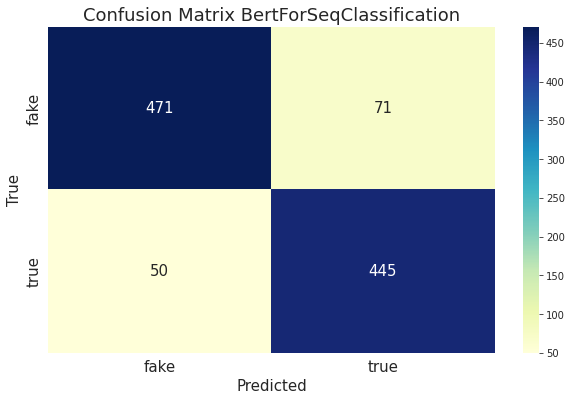

In [139]:
conf_matrix(cm=confusion_matrix(real_label,predicted_label),title='BertForSeqClassification')

In [178]:

error_pred = []
error_real = []
error_text = []
for pred,real,index in zip(predicted_label,real_label,range(len(real_label))): 
  if pred != real:
    error_pred.append(pred)
    error_real.append(real)
    error_text.append(tokenizer.decode(val_dataset[index][0]))
error_df = pd.DataFrame({'text':error_text,'prediction':error_pred,'real':error_real})
error_df

,text,prediction,real
0,[CLS] espana dara trabajo agricultores ecuator...,0,1
1,[CLS] camaras seguridad captan tres mujeres hu...,1,0
2,[CLS] presidente gobierno pedro sanchez acusad...,0,1
3,[CLS] ayanta barilli primera vez contacto sexu...,0,1
4,[CLS] fechas apertura calendario tentativo may...,1,0
...,...,...,...
116,[CLS] nacho cano devuelve borde lagrimas cruz ...,0,1
117,[CLS] recibir apoyo lopez obrador prohibe crit...,1,0
118,[CLS] uso compulsivo mascarillas ocasiona prop...,1,0
119,[CLS] covid infecta expande gracias unas molec...,0,1


In [163]:
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
    

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (31002, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (